# Buổi 05 | 04/05/2021

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1alE8uIDEo01abHfOmKOCsyFiNtGR4Qcf?usp=sharing)

In [1]:
import pdb
import operator
import itertools
import numpy as np
import matplotlib.pyplot as plt
import cv2


from matplotlib import colors
from scipy.spatial.distance import cdist
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation 
np.random.seed(2)

In [2]:
def cv(value_list):
  '''
  Takes a list of numbers and returns a column vector:  n x 1
  '''
  return np.transpose(rv(value_list))

In [3]:
def rv(value_list):
  '''
  Takes a list of numbers and returns a row vector: 1 x n
  '''
  return np.array([value_list])

In [4]:
def tidy_plot(xmin, xmax, ymin, ymax, center = False, title = None, xlabel = None, ylabel = None):
  '''
  Set up axes for plotting
  xmin, xmax, ymin, ymax = (float) plot extents
  Return matplotlib axes
  '''
  plt.ion()
  plt.figure(facecolor="white")
  ax = plt.subplot()
  if center:
      ax.spines['left'].set_position('zero')
      ax.spines['right'].set_color('none')
      ax.spines['bottom'].set_position('zero')
      ax.spines['top'].set_color('none')
      ax.spines['left'].set_smart_bounds(True)
      ax.spines['bottom'].set_smart_bounds(True)
      ax.xaxis.set_ticks_position('bottom')
      ax.yaxis.set_ticks_position('left')
  else:
      ax.spines["top"].set_visible(False)
      ax.spines["right"].set_visible(False)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()
  eps = .05
  plt.xlim(xmin-eps, xmax+eps)
  plt.ylim(ymin-eps, ymax+eps)
  if title: ax.set_title(title)
  if xlabel: ax.set_xlabel(xlabel)
  if ylabel: ax.set_ylabel(ylabel)
  return ax

In [5]:
def plot_separator(ax, th, th_0):
  '''
  Plot separator in 2D
  ax = (matplotlib plot) plot axis
  th = (numpy array) theta
  th_0 = (float) theta_0
  '''
  xmin, xmax = ax.get_xlim()
  ymin,ymax = ax.get_ylim()
  pts = []
  eps = 1.0e-6
  # xmin boundary crossing is when xmin th[0] + y th[1] + th_0 = 0
  # that is, y = (-th_0 - xmin th[0]) / th[1]
  if abs(th[1,0]) > eps:
    pts += [np.array([x, (-th_0 - x * th[0,0]) / th[1,0]]) for x in (xmin, xmax)]
  if abs(th[0,0]) > 1.0e-6:
    pts += [np.array([(-th_0 - y * th[1,0]) / th[0,0], y]) for y in (ymin, ymax)]
  in_pts = []
  for p in pts:
    if (xmin-eps) <= p[0] <= (xmax+eps) and (ymin-eps) <= p[1] <= (ymax+eps): 
      duplicate = False
      for p1 in in_pts:
        if np.max(np.abs(p - p1)) < 1.0e-6:
          duplicate = True
      if not duplicate:
        in_pts.append(p)
  if in_pts and len(in_pts) >= 2:
    # Plot separator
    vpts = np.vstack(in_pts)
    ax.plot(vpts[:,0], vpts[:,1], 'k-', lw=2)
    # Plot normal
    vmid = 0.5*(in_pts[0] + in_pts[1])
    scale = np.sum(th*th)**0.5
    diff = in_pts[0] - in_pts[1]
    dist = max(xmax-xmin, ymax-ymin)
    vnrm = vmid + (dist/10)*(th.T[0]/scale)
    vpts = np.vstack([vmid, vnrm])
    ax.plot(vpts[:,0], vpts[:,1], 'k-', lw=2)
    # Try to keep limits from moving around
    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
  else:
    print('Separator not in plot range')

In [6]:
def plot_data(data, labels, ax = None, clear = False, xmin = None, xmax = None, ymin = None, ymax = None):
  '''
  Make scatter plot of data.
  data = (numpy array)
  ax = (matplotlib plot)
  clear = (bool) clear current plot first
  xmin, xmax, ymin, ymax = (float) plot extents
  returns matplotlib plot on ax
  '''
  if ax is None:
    if xmin == None: xmin = np.min(data[0, :]) - 0.5
    if xmax == None: xmax = np.max(data[0, :]) + 0.5
    if ymin == None: ymin = np.min(data[1, :]) - 0.5
    if ymax == None: ymax = np.max(data[1, :]) + 0.5
    ax = tidy_plot(xmin, xmax, ymin, ymax)

    x_range = xmax - xmin; y_range = ymax - ymin
    if .1 < x_range / y_range < 10:
        ax.set_aspect('equal')
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
  elif clear:
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.clear()
  else:
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
  colors = np.choose(labels > 0, cv(['r', 'g']))[0]
  ax.scatter(data[0,:], data[1,:], c = colors, marker = 'o', s=50, edgecolors = 'none')
  # Seems to occasionally mess up the limits
  ax.set_xlim(xlim); ax.set_ylim(ylim)
  ax.grid(True, which='both')
  #ax.axhline(y=0, color='k')
  #ax.axvline(x=0, color='k')
  return ax

In [7]:
def test_linear_classifier(dataFun, learner, learner_params = {}, draw = False, refresh = True, pause = False):
  '''
  Prints score of your classifier on given dataset
  dataFun method that returns a dataset
  learner your classifier method
  learner_params parameters for the learner
  '''
  data, labels = dataFun()
  d, n = data.shape
  if draw:
    ax = plot_data(data, labels)
    def hook(params):
      (th, th0) = params
      if refresh: plot_data(data, labels, ax, clear = True)
      plot_separator(ax, th, th0)
      plt.pause(0.5)
      if pause: input('go?')
  else:
    hook = None
  th, th0 = learner(data, labels, hook = hook, params = learner_params)
  print("Params", np.transpose(th), th0)

In [8]:
def positive(x, th, th0):
  return np.sign(th.T @ x + th0)

In [9]:
def perceptron(data, labels, params={}, hook=None):
  T = params.get('T', 100)
  d, n = data.shape
  th = np.zeros((d, 1))
  th0 = 0
  for t in range(T):
    for i in range(n):
      x = data[:, i:i+1]
      y = labels[:, i:i+1]
      if y * positive(x, th, th0) <= 0:
        th += y*x
        th0 += y
        if hook:
          hook((th, th0))
  return th, th0

Separator not in plot range


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


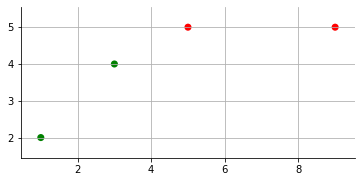

Separator not in plot range


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Separator not in plot range
Separator not in plot range


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Separator not in plot range


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obj

Separator not in plot range


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obj

Params [[-9.  6.]] [[5]]


In [10]:
def data_source():
  x = np.array([[1, 5, 3, 9], [2, 5, 4, 5]])
  y = np.array([[1, -1, 1, -1]])
  return x, y

test_linear_classifier(data_source, perceptron, draw=True, learner_params={'T':1000}, pause=False)

In [11]:
# generate data
# list of points 
means = [[2, 2], [4, 2]]
cov = [[.3, .2], [.2, .3]]
N = 10
X0 = np.random.multivariate_normal(means[0], cov, N).T
X1 = np.random.multivariate_normal(means[1], cov, N).T

X = np.concatenate((X0, X1), axis = 1)
y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis = 1)
# Xbar 
X = np.concatenate((np.ones((1, 2*N)), X), axis = 0)

In [12]:
def h(w, x):    
  return np.sign(np.dot(w.T, x))

In [13]:
def has_converged(X, y, w):    
  return np.array_equal(h(w, X), y) 

In [14]:
def perceptron(X, y, w_init):
  w = [w_init]
  N = X.shape[1]
  d = X.shape[0]
  mis_points = []
  while True:
    # mix data 
    mix_id = np.random.permutation(N)
    for i in range(N):
      xi = X[:, mix_id[i]].reshape(d, 1)
      yi = y[0, mix_id[i]]
      if h(w[-1], xi)[0] != yi: # misclassified point
          mis_points.append(mix_id[i])
          w_new = w[-1] + yi*xi 
          w.append(w_new)
            
    if has_converged(X, y, w[-1]):
      break
  return (w, mis_points)

d = X.shape[0]
w_init = np.random.randn(d, 1)
(w, m) = perceptron(X, y, w_init)
print(m)
# print(w)
# print(len(w))

[7, 10, 0, 18, 3, 6, 14, 9, 7, 17, 0, 19, 3, 2, 12, 6, 11, 7]


In [15]:
def draw_line(w):
    w0, w1, w2 = w[0], w[1], w[2]
    if w2 != 0:
        x11, x12 = -100, 100
        return plt.plot([x11, x12], [-(w1*x11 + w0)/w2, -(w1*x12 + w0)/w2], 'k')
    else:
        x10 = -w0/w1
        return plt.plot([x10, x10], [-100, 100], 'k')

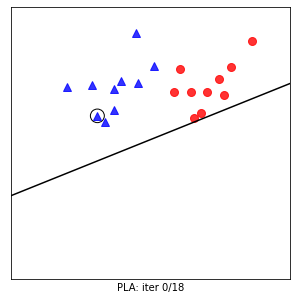

In [16]:
def viz_alg_1d_2(w):
    it = len(w)    
    fig, ax = plt.subplots(figsize=(5, 5))  
    
    def update(i):
        ani = plt.cla()
        #points
        ani = plt.plot(X0[0, :], X0[1, :], 'b^', markersize = 8, alpha = .8)
        ani = plt.plot(X1[0, :], X1[1, :], 'ro', markersize = 8, alpha = .8)
        ani = plt.axis([0 , 6, -2, 4])
        i2 =  i if i < it else it-1
        ani = draw_line(w[i2])
        if i < it-1:
            # draw one  misclassified point
            circle = plt.Circle((X[1, m[i]], X[2, m[i]]), 0.15, color='k', fill = False)
            ax.add_artist(circle)
        # hide axis 
        cur_axes = plt.gca()
        cur_axes.axes.get_xaxis().set_ticks([])
        cur_axes.axes.get_yaxis().set_ticks([])

        label = 'PLA: iter %d/%d' %(i2, it-1)
        ax.set_xlabel(label)
        return ani, ax 
        
    anim = FuncAnimation(fig, update, frames=np.arange(0, it + 2), interval=1000)
    # save 
    #anim.save('pla_vis.gif', dpi = 100, writer = 'imagemagick')
    plt.show()
    
viz_alg_1d_2(w)